In [1]:
import numpy as np
from numpy import linalg
import random
import matplotlib.pyplot as plt
import matplotlib.patches
import math
from math import atan2
from math import sin
from math import cos
from math import log
from ipywidgets import FloatProgress
from IPython.display import display
from numba import jit
from __future__ import division
import time

def RandomPointsOnCircle(radius, number_of_points):
    points = []
    count = 0
    while count < number_of_points:
        point = False
        while point == False:
            random_x = random.uniform(-1, 1)
            random_y = random.uniform(-1, 1)
            if random_x ** 2 + random_y ** 2 <= radius:
                points.append([random_x, random_y])
                count += 1
                point = True
                
    return(np.array(points))

def distance(r, number_of_points):
    D = np.zeros((number_of_points, number_of_points))
    for i in range(number_of_points):
        for j in range(i, number_of_points):
            D[i, j] = np.linalg.norm(r[i] - r[j])
            D[j, i] = D[i, j]
    return(D)

def energy(D):
    energies = []
    for i in range(len(D[0,:])):
        for j in range(len(D[:,0])):
            if i == j:
                break
            energies.append(1 / D[i, j])
    total_energy = sum(energies)
    return(total_energy)

def ForceVector(points, number_of_points):
    F = np.zeros((number_of_points, 2))
    for i in range(number_of_points):
        F[i] = points[i] 
        for j in range(number_of_points):
            if j != i:
                F[i] += points[j]
    return(F)

def ForcePerturbation(points, number_of_points, radius, std, version):
    D = distance(points, number_of_points)
    if version == 1:
        Force = ForceVector(points, number_of_points)
        F = [sum(D[:,i])**3 for i in range(number_of_points)]
        Force = [Force[i]/F[i] for i in range(number_of_points)]
        absForce = [np.linalg.norm(Force[i]) for i in range(number_of_points)]
        highEpoint = np.argmax(absForce)
    else:
        F = [sum(D[:,i]) / sum(D[:,i])**3 for i in range(number_of_points)]
        highEpoint = np.argmax(F)
    
    x = points[highEpoint, 0]
    y = points[highEpoint, 1]
    
    #new_x = x + np.random.normal(0, (std * radius))
    #new_y = y + np.random.normal(0, (std * radius))
    
    new_x = x + np.random.uniform(-std, std)
    new_y = y + np.random.uniform(-std, std)
    
    if new_x ** 2 + new_y ** 2 <= radius:
        points[highEpoint, 0] = new_x
        points[highEpoint, 1] = new_y
    else:
        myradians = math.atan2(new_x, new_y)
        points[highEpoint, 0] = cos(myradians)
        points[highEpoint, 1] = sin(myradians)
    
    return(points)

# This function compared to the one above will not deterministically select a point. Points will have a higher 
# chance of being selected based on their energy contribution. 

def RandomizedForcePerturbation(points, number_of_points, radius, std, version):
    D = distance(points, number_of_points)
    if version == 1:
        Force = ForceVector(points, number_of_points)
        F = [sum(D[:,i])**3 for i in range(number_of_points)]
        Force = [Force[i]/F[i] for i in range(number_of_points)]
        absForce = [np.linalg.norm(Force[i]) for i in range(number_of_points)]

    else:
        Sorted_D = np.zeros((number_of_points, number_of_points))
        Sorted_D = [np.sort(D[:,i]) for i in range(number_of_particles)]
        absForce = [sum(Sorted_D[i, int(number_of_particles/2):]) for i in range(number_of_particles)]
        #F = [sum(D[:,i])**3 for i in range(number_of_points)]
        #Force = [Force[i]/F[i] for i in range(number_of_points)]
        #absForce = [np.linalg.norm(Force[i]) for i in range(number_of_points)]
        
    # Give a randomized chance of being picked based on your energy contribution
    cumulative_force = [sum(absForce[0:(i)]) for i in range(number_of_points)]
    Range = max(absForce)
    Random_number = random.uniform(0, 1) * Range
    inequality_vector = [0 if force < Random_number else 1 for force in cumulative_force]
    while True:
        try:
            highEpoint = inequality_vector.index(1)
            break
        except ValueError:
            highEpoint = number_of_points - 1
            break
    
    x = points[highEpoint, 0]
    y = points[highEpoint, 1]
    
    #necessary_displacement = absForce[highEpoint]/max(absForce)
    
    #new_x = x + np.random.normal(0, (std * radius))
    #new_y = y + np.random.normal(0, (std * radius))
    
    new_x = x + np.random.uniform(-std, std)
    new_y = y + np.random.uniform(-std, std)
    
    if new_x ** 2 + new_y ** 2 <= radius:
        points[highEpoint, 0] = new_x
        points[highEpoint, 1] = new_y
    else:
        myradians = math.atan2(new_x, new_y)
        points[highEpoint, 0] = cos(myradians)
        points[highEpoint, 1] = sin(myradians)
    
    return(points)

def SimulatedAnnealing(radius, number_of_points, T_iterations, N_iterations, Temp, std):
    # create a random arrangements of points on a circle
    initial_points = RandomPointsOnCircle(radius, number_of_points)
    
    # initiate a loop that will loop a number of times equal to the iterations

    for x in range(T_iterations):
        Temp = Temp*log(x+2)
        for y in range(N_iterations):
            # calculate the energy of the old points
            distance_matrix = distance(initial_points, number_of_points)
            initial_energy = energy(distance_matrix)
            
            # generate a new set of points, and calculate distances and energy
            new_points = ForcePerturbation(initial_points, number_of_points, radius, std, 1)
            distance_matrix = distance(new_points, number_of_points)
            new_energy = energy(distance_matrix)
            
            # calculate the difference between the initial and new arrangements of particles 
            dE = initial_energy - new_energy
            # decide whether to pick the new arrangement or keep the old one
            if dE > 0:
                initial_points = new_points
                #A = np.vstack((A, initial_points[None]))
            else:
                Random = random.uniform(0, 1)
                p = math.exp(dE * Temp)
                if Random >= p:
                    initial_points = new_points
                    #A = np.vstack((A, initial_points[None]))
                else:
                    break
                    
    return(initial_points)

def Run(points, T_iterations, N_iterations, init_T, std):
    start = time.clock()
    Final_points = SimulatedAnnealing(1, points, T_iterations, N_iterations, init_T, std)
    
    end = time.clock()
    #print end - start
    final_energy = energy(distance(Final_points, points))
    #print final_energy
    
    return(final_energy, Final_points)

def Experiment(Runs, points, T_iterations, N_iterations, init_T, std):
    Energies = []
    Final_Points = np.zeros((2, points))
    minimum_energy = 10000
    for x in range(Runs):
        final_energy, final_points = Run(points, T_iterations, N_iterations, init_T, std)
        Energies.append(final_energy)
        
        if final_energy < minimum_energy:
            minimum_energy = final_energy
            minimum_run = x
            Final_Points = final_points
    
    circle1 = matplotlib.patches.Circle((0,0), 1, Fill=False, linestyle="dashed")

    fig, ax = plt.subplots()

    ax.add_artist(circle1)

    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.scatter(Final_Points[:,0], Final_Points[:,1])
    plt.plot([0, 0], [-1, 1], color='k', linestyle='--', linewidth=0.5)
    plt.plot([-1, 1], [0, 0], color='k', linestyle='--', linewidth=0.5)
    plt.plot([-1, 1], [-1, 1], color='k', linestyle='--', linewidth=0.5)
    plt.plot([-1, 1], [1, -1], color='k', linestyle='--', linewidth=0.5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Configuration N=%i, E=%f"%(points, minimum_energy))
    plt.savefig("Experiment %i" %points)
    plt.show()
    return(minimum_energy, Final_Points)

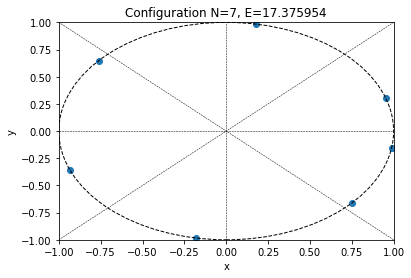

(17.375953968586781, array([[ 0.95199638,  0.30610929],
        [-0.93539853, -0.35359522],
        [ 0.17509366,  0.98455178],
        [ 0.98750689, -0.15757582],
        [ 0.75283552, -0.65820869],
        [-0.76066147,  0.64914878],
        [-0.17837177, -0.98396317]]))

In [64]:
Experiment(1, 7, 10, 1000, 1, 1)

In [70]:
a, Final_Points = Run(16, 100, 10000, 1, 1)

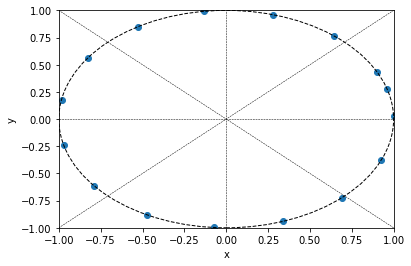

In [71]:
circle1 = matplotlib.patches.Circle((0,0), 1, Fill=False, linestyle="dashed")

fig, ax = plt.subplots()

ax.add_artist(circle1)

plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.scatter(Final_Points[:,0], Final_Points[:,1])
plt.plot([0, 0], [-1, 1], color='k', linestyle='--', linewidth=0.5)
plt.plot([-1, 1], [0, 0], color='k', linestyle='--', linewidth=0.5)
plt.plot([-1, 1], [-1, 1], color='k', linestyle='--', linewidth=0.5)
plt.plot([-1, 1], [1, -1], color='k', linestyle='--', linewidth=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [45]:
# Test the optimal configuration of particles for N = 7 - 11.

for x in range(7, 11):
    Experiment(10, x, 10, 1000, 1, 1)

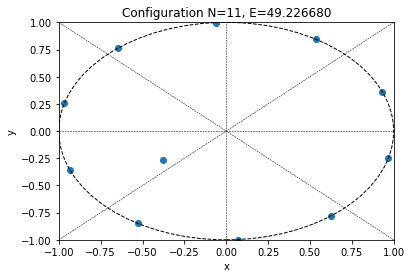

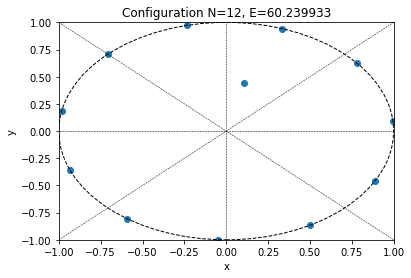

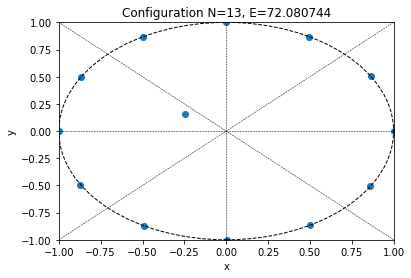

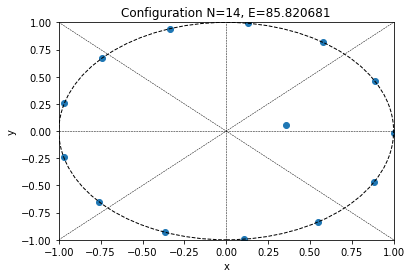

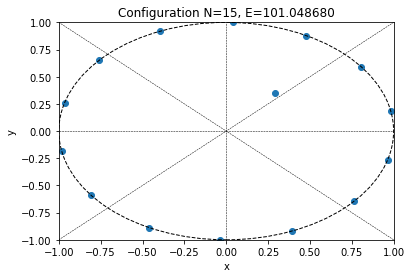

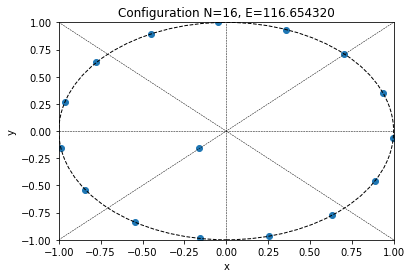

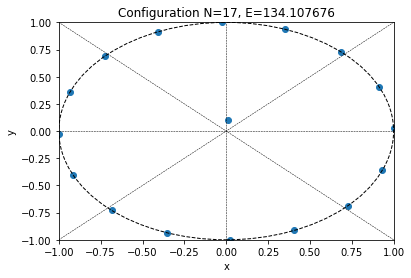

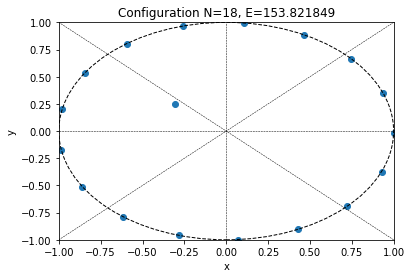

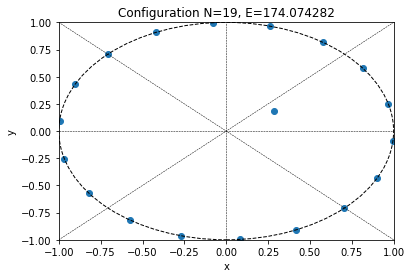

In [65]:
# Test the optimal configuration of particles for N = 12 - 20.

for x in range(11, 20):
    Experiment(10, x, 10, 1000, 1, 1)